# Bagging & Boosting, KNN & Stacking

## Question 1
**What is the fundamental idea behind ensemble techniques? How does bagging differ from boosting in terms of approach and objective?**

**Answer:**

Ensemble techniques combine multiple base models (often called weak learners) to produce a single, stronger model. The core idea is that aggregating diverse models reduces variance and/or bias and improves generalization compared to individual models. The most common ensemble strategies are bagging, boosting, and stacking.

- **Bagging (Bootstrap Aggregating):**
  - Approach: Train multiple models independently on different bootstrap samples (random samples with replacement) of the training set, then aggregate their predictions (majority vote for classification or average for regression).
  - Objective: Reduce variance and avoid overfitting (especially helpful for high-variance models like decision trees). Each model sees a different subset of data, making their errors less correlated.

- **Boosting:**
  - Approach: Train models sequentially; each new model focuses on correcting mistakes made by the ensemble so far by re-weighting training instances (or fitting residuals). Examples: AdaBoost, Gradient Boosting, XGBoost, LightGBM, CatBoost.
  - Objective: Reduce bias (and often variance) by combining weak learners iteratively into a strong learner. Boosting typically yields higher accuracy but is more prone to overfitting if not regularized.

In short: bagging builds independent models in parallel to reduce variance; boosting builds models sequentially to reduce bias by focusing on hard examples.


## Question 2
**Explain how the Random Forest Classifier reduces overfitting compared to a single decision tree. Mention the role of two key hyperparameters in this process.**

**Answer:**

Random Forest reduces overfitting by creating an ensemble of de-correlated decision trees and averaging their predictions. Key mechanisms:

1. **Bootstrap sampling**: Each tree is trained on a different bootstrap sample of the training set (sampling with replacement). This produces diversity among trees.
2. **Random feature selection**: At each split, a random subset of features is considered (rather than all features). This prevents dominant features from being used by every tree and increases diversity.

Two important hyperparameters:
- `n_estimators`: Number of trees in the forest. More trees generally improve performance and stabilize predictions (reduce variance) up to a point, at cost of compute.
- `max_features`: Number (or fraction) of features to consider when looking for the best split. Smaller `max_features` increases diversity between trees (reducing correlation) and thus reduces overfitting; too small may increase bias.

Other helpful hyperparameters: `max_depth` (limits tree size to reduce each tree's variance) and `min_samples_leaf` (prevents leaves with too few samples). Combining many moderately complex but de-correlated trees yields a robust ensemble that generalizes better than a single deep decision tree.


## Question 3
**What is Stacking in ensemble learning? How does it differ from traditional bagging/boosting methods? Provide a simple example use case.**

**Answer:**

**Stacking (stacked generalization)** trains multiple base models (level-0) and then trains a meta-model (level-1) that learns to combine base models' predictions. The meta-model is trained on out-of-fold predictions from the base models to avoid data leakage.

Differences vs bagging/boosting:
- **Bagging** averages models trained in parallel on bootstrapped datasets. **Boosting** trains models sequentially, each focusing on previous errors. Both produce a direct aggregated output (vote/average or weighted sum).
- **Stacking** learns how to combine different model predictions by training a separate learner on those predictions. It's more flexible because the meta-learner can learn complex combinations (non-linear stacking), and base learners can be heterogeneous (e.g., logistic regression, random forest, SVM).

**Use case:** Suppose you build three classifiers for tabular data: a random forest, an SVM, and a logistic regression. Each has different strengths. Train them as base learners and then train a small gradient boosting machine or logistic regression as the meta-learner on the base predictions — this often yields better performance than any single base model.


## Question 4
**What is the OOB Score in Random Forest, and why is it useful? How does it help in model evaluation without a separate validation set?**

**Answer:**

OOB (Out-Of-Bag) score is an internal validation score computed by Random Forest using the samples that were *not* included* in the bootstrap sample for each tree. For each training instance, predictions are aggregated from trees that did not use that instance during training. The aggregated predictions are then compared to the true labels to compute an OOB accuracy (or other metric).

Why it's useful:
- Provides a nearly unbiased estimate of generalization performance without needing a separate validation set or cross-validation, saving data for training.
- Helpful for quick hyperparameter tuning and model selection when data is limited.

Limitations: OOB estimates are most reliable for classification and regression with a reasonable number of trees; if `n_estimators` is small, OOB estimates can be noisy.


## Question 5
**Compare AdaBoost and Gradient Boosting in terms of:**
- **How they handle errors from weak learners**
- **Weight adjustment mechanism**
- **Typical use cases**

**Answer:**

- **Error handling**:
  - **AdaBoost:** Adjusts instance weights after each weak learner; misclassified points get higher weight so the next learner focuses on them. The final prediction is a weighted vote of learners.
  - **Gradient Boosting:** Fits each subsequent learner to the residual errors (negative gradient of the loss function) of the ensemble so far. It is a functional gradient descent approach.

- **Weight adjustment mechanism:**
  - **AdaBoost:** Updates sample weights multiplicatively based on whether a sample was correctly classified; also computes an alpha weight for each weak learner based on its error.
  - **Gradient Boosting:** Uses gradient information (residuals) to fit the next model; combination weights are usually a learning rate times the fitted model outputs.

- **Typical use cases:**
  - **AdaBoost:** Works well with simple base learners (e.g., shallow decision trees) and on relatively clean data; historically popular but often outperformed by gradient boosting variants.
  - **Gradient Boosting (and its efficient implementations like XGBoost/LightGBM/CatBoost):** State-of-the-art for many tabular problems, handling different loss functions, regularization, and large datasets. CatBoost is especially strong for categorical features, while LightGBM and XGBoost are optimized for large-scale problems.


## Question 6
**Why does CatBoost perform well on categorical features without requiring extensive preprocessing? Briefly explain its handling of categorical variables.**

**Answer:**

CatBoost uses a combination of techniques to handle categorical variables effectively:
- **Ordered target statistics:** CatBoost computes target-based statistics for categories (e.g., mean target per category) using an order-aware scheme that prevents target leakage (by only using earlier samples to compute statistics for the current sample).
- **Combinations of categorical features:** It can automatically create combinations of categorical features to capture interactions.
- **Robust encoding & regularization:** The encoding incorporates randomness and smoothing to avoid overfitting to rare categories.

Together these techniques allow CatBoost to ingest categorical columns directly (with a `cat_features` parameter) and get strong performance without heavy manual encoding like one-hot encoding or target leakage-prone mean encodings.


---
# Practical tasks (Q7 – Q10)

In [1]:

# Question 7: KNN Classifier Assignment — Wine dataset analysis with optimization
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
data = load_wine()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

# Train-test split 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Default KNN (k=5) without scaling
knn_default = KNeighborsClassifier(n_neighbors=5)
knn_default.fit(X_train, y_train)
y_pred_default = knn_default.predict(X_test)

print("== KNN (k=5) WITHOUT scaling ==")
print("Accuracy:", accuracy_score(y_test, y_pred_default))
print(classification_report(y_test, y_pred_default, target_names=target_names))

# Scaling with StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_scaled = KNeighborsClassifier(n_neighbors=5)
knn_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = knn_scaled.predict(X_test_scaled)

print("== KNN (k=5) WITH StandardScaler ==")
print("Accuracy:", accuracy_score(y_test, y_pred_scaled))
print(classification_report(y_test, y_pred_scaled, target_names=target_names))

# GridSearchCV to find best K and metric
param_grid = {
    'n_neighbors': list(range(1,21)),
    'p': [1, 2],          # p=1 -> Manhattan, p=2 -> Euclidean
    'weights': ['uniform', 'distance']
}
knn_for_search = KNeighborsClassifier()
grid = GridSearchCV(knn_for_search, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("Best params (GridSearch):", grid.best_params_)
print("Best CV score:", grid.best_score_)

# Train optimized KNN on scaled data
best_knn = grid.best_estimator_
y_pred_best = best_knn.predict(X_test_scaled)

print("== Optimized KNN ON SCALED DATA ==")
print("Test Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, target_names=target_names))

# Summary
import pandas as pd
results = {
    'Model': ['KNN_default_unscaled', 'KNN_default_scaled', 'KNN_optimized_scaled'],
    'Accuracy': [accuracy_score(y_test, y_pred_default), accuracy_score(y_test, y_pred_scaled), accuracy_score(y_test, y_pred_best)]
}
print(pd.DataFrame(results))


== KNN (k=5) WITHOUT scaling ==
Accuracy: 0.7222222222222222
              precision    recall  f1-score   support

     class_0       0.89      0.89      0.89        18
     class_1       0.78      0.67      0.72        21
     class_2       0.50      0.60      0.55        15

    accuracy                           0.72        54
   macro avg       0.72      0.72      0.72        54
weighted avg       0.74      0.72      0.73        54

== KNN (k=5) WITH StandardScaler ==
Accuracy: 0.9444444444444444
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        18
     class_1       1.00      0.86      0.92        21
     class_2       0.83      1.00      0.91        15

    accuracy                           0.94        54
   macro avg       0.94      0.95      0.94        54
weighted avg       0.95      0.94      0.94        54

Best params (GridSearch): {'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}
Best CV score: 0.9756666666666666
== 

In [3]:
import warnings
warnings.filterwarnings("ignore")

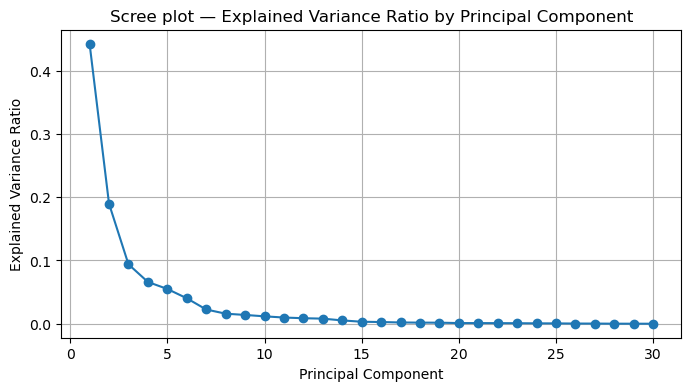

Original dimensions: (569, 30)
Reduced dimensions (95% variance): 10
KNN accuracy on original (scaled) data: 0.9707602339181286
KNN accuracy on PCA (95% var) data: 0.9473684210526315


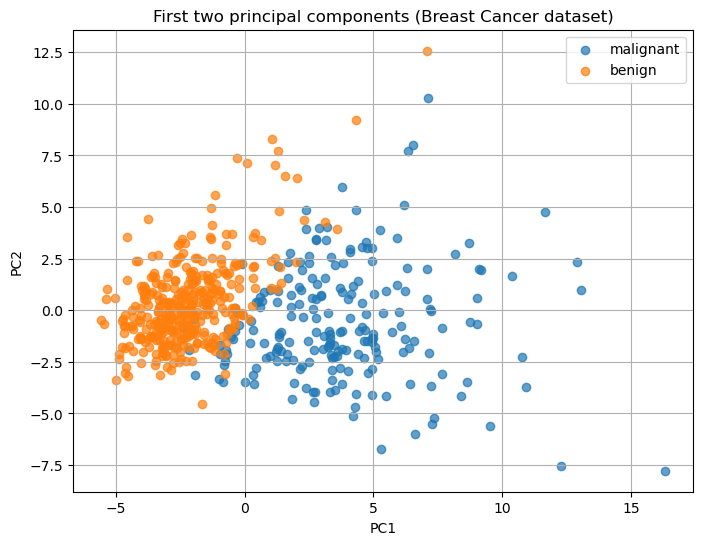

In [4]:

# Question 8: PCA + KNN with Variance Analysis and Visualization
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load dataset
data = load_breast_cancer()
X = data.data
y = data.target
target_names = data.target_names

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA fit
pca = PCA()
pca.fit(X_scaled)
explained = pca.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, len(explained)+1), explained, marker='o')
plt.title('Scree plot — Explained Variance Ratio by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Retain 95% variance
pca95 = PCA(n_components=0.95)
X_pca95 = pca95.fit_transform(X_scaled)
print("Original dimensions:", X.shape)
print("Reduced dimensions (95% variance):", X_pca95.shape[1])

# Train-test split
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42, stratify=y)
X_train_pca, X_test_pca, _, _ = train_test_split(X_pca95, y, test_size=0.30, random_state=42, stratify=y)

# KNN on original
knn_orig = KNeighborsClassifier(n_neighbors=5)
knn_orig.fit(X_train_orig, y_train)
y_pred_orig = knn_orig.predict(X_test_orig)
acc_orig = accuracy_score(y_test, y_pred_orig)

# KNN on PCA-transformed
knn_pca = KNeighborsClassifier(n_neighbors=5)
knn_pca.fit(X_train_pca, y_train)
y_pred_pca = knn_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca)

print("KNN accuracy on original (scaled) data:", acc_orig)
print("KNN accuracy on PCA (95% var) data:", acc_pca)

# Scatter plot of first two principal components
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
for cls in np.unique(y):
    mask = y == cls
    plt.scatter(X_pca2[mask,0], X_pca2[mask,1], label=target_names[cls], alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First two principal components (Breast Cancer dataset)')
plt.legend()
plt.grid(True)
plt.show()


MSE (K=5, Euclidean): 4803.90558674207
MSE (K=5, Manhattan): 5210.225816542468


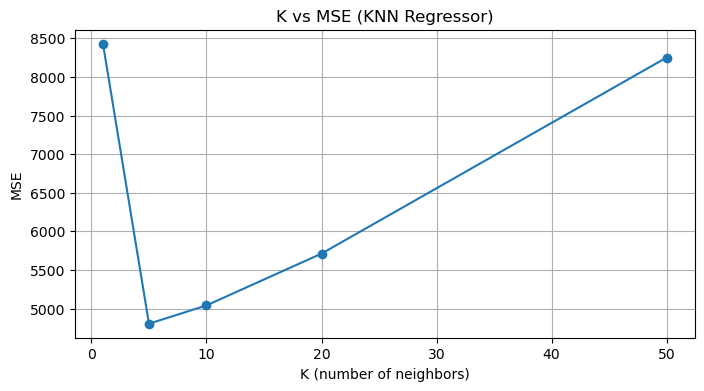

K values: [1, 5, 10, 20, 50]
Corresponding MSEs: [8430.421228238532, 4803.90558674207, 5041.107684099525, 5712.019124800163, 8251.371312581607]


In [5]:

# Question 9: KNN Regressor with Distance Metrics and K-Value Analysis
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Generate data
X, y = make_regression(n_samples=500, n_features=10, noise=10.0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# K=5 Euclidean (p=2)
knn_euc = KNeighborsRegressor(n_neighbors=5, p=2)
knn_euc.fit(X_train, y_train)
y_pred_euc = knn_euc.predict(X_test)
mse_euc = mean_squared_error(y_test, y_pred_euc)

# K=5 Manhattan (p=1)
knn_man = KNeighborsRegressor(n_neighbors=5, p=1)
knn_man.fit(X_train, y_train)
y_pred_man = knn_man.predict(X_test)
mse_man = mean_squared_error(y_test, y_pred_man)

print("MSE (K=5, Euclidean):", mse_euc)
print("MSE (K=5, Manhattan):", mse_man)

# K vs MSE
k_values = [1,5,10,20,50]
mses = []
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    mses.append(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(8,4))
plt.plot(k_values, mses, marker='o')
plt.title('K vs MSE (KNN Regressor)')
plt.xlabel('K (number of neighbors)')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

print("K values:", k_values)
print("Corresponding MSEs:", mses)


Comparison (algorithm, train_time_sec, accuracy):
   algorithm  train_time_sec  accuracy
0      brute        0.001408   0.69697
1    kd_tree        0.001616   0.69697
2  ball_tree        0.004430   0.69697
Top two feature indices used for decision boundary: [1 4]


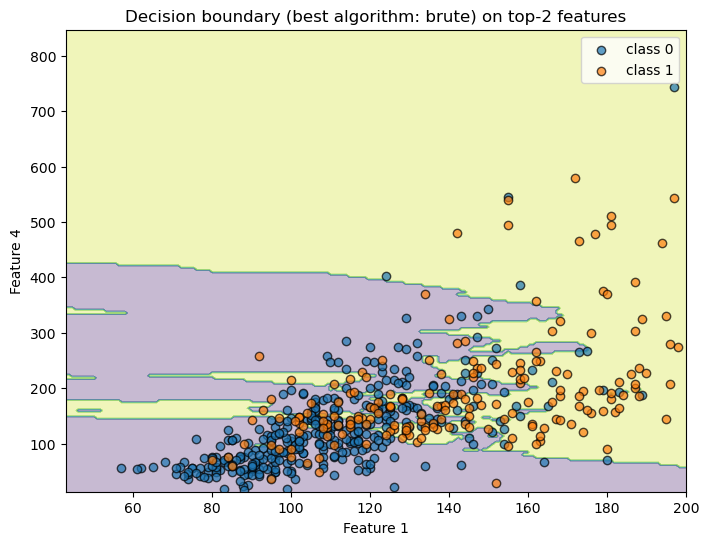

In [6]:

# Question 10: KNN with KD-Tree/Ball Tree, Imputation, and Real-World Data (Pima Indians Diabetes)
import time
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Dataset URL
url = "https://raw.githubusercontent.com/MasteriNeuron/datasets/refs/heads/main/diabetes.csv"

# Load dataset (requires internet when running notebook)
try:
    df = pd.read_csv(url)
except Exception as e:
    print("Could not download dataset in this execution environment. When you run this notebook locally or on Colab, make sure internet is enabled.")
    from sklearn.datasets import make_classification
    Xs, ys = make_classification(n_samples=200, n_features=8, n_informative=6, random_state=42)
    df = pd.DataFrame(Xs, columns=[f'feat{i}' for i in range(Xs.shape[1])])
    df['Outcome'] = ys

possible_zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in possible_zero_cols:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)

# Separate features and target
if 'Outcome' in df.columns:
    X = df.drop(columns=['Outcome']).values
    y = df['Outcome'].values
else:
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

# KNN imputation
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.30, random_state=42, stratify=y if len(np.unique(y))>1 else None)

# Compare algorithms
algorithms = ['brute', 'kd_tree', 'ball_tree']
results = []
for algo in algorithms:
    clf = KNeighborsClassifier(n_neighbors=5, algorithm=algo)
    t0 = time.time()
    clf.fit(X_train, y_train)
    t1 = time.time()
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({'algorithm': algo, 'train_time_sec': t1-t0, 'accuracy': acc})

print("Comparison (algorithm, train_time_sec, accuracy):")
print(pd.DataFrame(results))

# Feature importance to pick two features (use Random Forest)
try:
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    importances = rf.feature_importances_
    top2_idx = np.argsort(importances)[-2:][::-1]
except Exception as e:
    top2_idx = np.argsort(np.var(X_imputed, axis=0))[-2:][::-1]

print("Top two feature indices used for decision boundary:", top2_idx)

# Decision boundary plot for best-performing method
best_algo = max(results, key=lambda x: x['accuracy'])['algorithm']
best_clf = KNeighborsClassifier(n_neighbors=5, algorithm=best_algo)
best_clf.fit(X_train[:, top2_idx], y_train)

# Create meshgrid
x_min, x_max = X_imputed[:, top2_idx[0]].min() - 1, X_imputed[:, top2_idx[0]].max() + 1
y_min, y_max = X_imputed[:, top2_idx[1]].min() - 1, X_imputed[:, top2_idx[1]].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]

Z = best_clf.predict(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3)
for cls in np.unique(y_train):
    mask = y_train == cls
    plt.scatter(X_train[mask, top2_idx[0]], X_train[mask, top2_idx[1]], label=f'class {cls}', edgecolor='k', alpha=0.7)
plt.xlabel(f'Feature {top2_idx[0]}')
plt.ylabel(f'Feature {top2_idx[1]}')
plt.title(f'Decision boundary (best algorithm: {best_algo}) on top-2 features')
plt.legend()
plt.show()
